# GroupBy processing

## Packages

In [1]:
import pandas as pd
import sqlite3
import duckdb

## Get data for our demo

Let's get some date for our exercise. We find those data on the open-data portal of Statbel. This [link](https://statbel.fgov.be/fr/open-data/population-par-lieu-de-residence-nationalite-etat-civil-age-et-sexe-14) will lead you here:

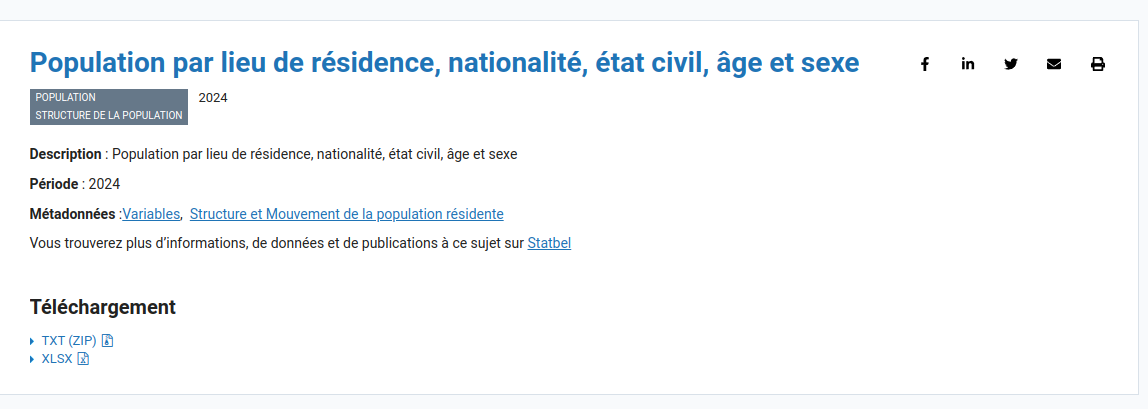

We import the `txt` file using the `pandas` `read_csv` function.

In [2]:
url='https://statbel.fgov.be/sites/default/files/files/opendata/bevolking%20naar%20woonplaats%2C%20nationaliteit%20burgelijke%20staat%20%2C%20leeftijd%20en%20geslacht/TF_SOC_POP_STRUCT_2024.zip'

In [3]:
population=pd.read_csv(url,sep='|',encoding='utf-8')

In [4]:
population.sample(3)

,CD_REFNIS,TX_DESCR_NL,TX_DESCR_FR,CD_DSTR_REFNIS,TX_ADM_DSTR_DESCR_NL,TX_ADM_DSTR_DESCR_FR,CD_PROV_REFNIS,TX_PROV_DESCR_NL,TX_PROV_DESCR_FR,CD_RGN_REFNIS,...,TX_RGN_DESCR_FR,CD_SEX,CD_NATLTY,TX_NATLTY_NL,TX_NATLTY_FR,CD_CIV_STS,TX_CIV_STS_NL,TX_CIV_STS_FR,CD_AGE,MS_POPULATION
364293,63067,Sankt Vith,Saint-Vith,63000,Arrondissement Verviers,Arrondissement de Verviers,60000.0,Provincie Luik,Province de Liège,3000,...,Région wallonne,M,BEL,Belgen,Belges,2,Gehuwd,Marié,87,11
183134,34027,Menen,Menin,34000,Arrondissement Kortrijk,Arrondissement de Courtrai,30000.0,Provincie West-Vlaanderen,Province de Flandre occidentale,2000,...,Région flamande,F,ETR,niet-Belgen,non-Belges,2,Gehuwd,Marié,67,4
286650,53068,Quiévrain,Quiévrain,53000,Arrondissement Bergen,Arrondissement de Mons,50000.0,Provincie Henegouwen,Province du Hainaut,3000,...,Région wallonne,F,ETR,niet-Belgen,non-Belges,3,Weduwstaat,Veuf,85,2


## GroupBy processing with Pandas

[Direct link to documentation](https://pandas.pydata.org/docs/reference/groupby.html#groupby)

Example of groupby computation directly on the `Pandas DataFrame`.

In [66]:
population.groupby('TX_PROV_DESCR_FR').agg(population_sum=('MS_POPULATION','sum'), 
                                           population_max=('MS_POPULATION','max'))

,population_sum,population_max
TX_PROV_DESCR_FR,,
Province de Flandre occidentale,1226375,641
Province de Flandre orientale,1572002,2109
Province de Liège,1119038,1220
Province de Namur,503895,726
Province du Brabant flamand,1196773,792
Province du Brabant wallon,414130,275
Province du Hainaut,1360074,1230
Province du Limbourg,900098,422
Province du Luxembourg,295146,189


Available functions for `GroupBy` processing are listed [here](https://pandas.pydata.org/docs/reference/groupby.html#dataframegroupby-computations-descriptive-stats). Common functions used by statisticiens include:
- min
- max
- sum
- std
- mean
- median
- quantile
- rank
- nunique


## GroupBy processing with duckdb

Similar results can be obtained with `duckdb`

In [9]:
import duckdb

In [14]:
duckdb.sql('''
select TX_PROV_DESCR_FR,
       sum(MS_POPULATION) as total_population,
       max(MS_POPULATION) as max_population
from population
group by TX_PROV_DESCR_FR
order by 1
''')

┌─────────────────────────────────┬──────────────────┬────────────────┐
│        TX_PROV_DESCR_FR         │ total_population │ max_population │
│             varchar             │      int128      │     int64      │
├─────────────────────────────────┼──────────────────┼────────────────┤
│ Province de Flandre occidentale │          1226375 │            641 │
│ Province de Flandre orientale   │          1572002 │           2109 │
│ Province de Liège               │          1119038 │           1220 │
│ Province de Namur               │           503895 │            726 │
│ Province du Brabant flamand     │          1196773 │            792 │
│ Province du Brabant wallon      │           414130 │            275 │
│ Province du Hainaut             │          1360074 │           1230 │
│ Province du Limbourg            │           900098 │            422 │
│ Province du Luxembourg          │           295146 │            189 │
│ Province d’Anvers               │          1926522 │          

## GroupBy processing with SQLite3

We cannot use DataFrame directly in our SQLite3 SQLs. We first have to create a database and load the DataFrame in this database.

In [30]:
import sqlite3

db=sqlite3.connect(':memory:')

In [32]:
population.to_sql('population',db,if_exists='replace')

476319

In [67]:
pd.read_sql('''
select TX_PROV_DESCR_FR,
       sum(MS_POPULATION) as total_population,
       max(MS_POPULATION) as max_population
from population
group by TX_PROV_DESCR_FR
order by 1
''',db)

,TX_PROV_DESCR_FR,total_population,max_population
0,None,1249597,1012
1,Province de Flandre occidentale,1226375,641
2,Province de Flandre orientale,1572002,2109
3,Province de Liège,1119038,1220
4,Province de Namur,503895,726
5,Province du Brabant flamand,1196773,792
6,Province du Brabant wallon,414130,275
7,Province du Hainaut,1360074,1230
8,Province du Limbourg,900098,422
9,Province du Luxembourg,295146,189


## Create your own Pandas aggregate function

In [44]:
def showSumElelments(x):
    return('+'.join([str(y) for y in x]))

In [46]:
population.groupby('TX_PROV_DESCR_FR').agg(population_sum=('MS_POPULATION',showSumElelments))

,population_sum
TX_PROV_DESCR_FR,
Province de Flandre occidentale,5+2+3+1+5+3+6+7+2+1+2+5+1+3+1+3+2+1+73+6+1+3+3...
Province de Flandre orientale,482+395+265+4+3+46+357+14+68+297+75+384+78+383...
Province de Liège,7+1+1+1+4+3+1+2+4+2+1+6+1+1+4+1+1+2+2+3+2+1+1+...
Province de Namur,23+25+19+14+21+22+21+34+22+7+21+6+14+6+3+20+1+...
Province du Brabant flamand,25+18+47+43+47+26+37+31+5+38+29+4+11+17+17+28+...
Province du Brabant wallon,6+20+3+2+29+18+19+9+28+23+28+41+27+5+17+1+37+1...
Province du Hainaut,3+3+5+161+201+7+67+141+103+147+100+143+17+122+...
Province du Limbourg,5+4+40+28+22+38+40+3+21+15+21+21+49+24+1+1+5+2...
Province du Luxembourg,10+9+14+43+3+1+42+16+14+16+47+26+1+89+2+68+7+1...


## Create your own Duckdb aggregate function

Not yet implemented in Duckdb

## Create your own Sqlite3 aggregate function

[Direct link to documentation](https://docs.python.org/3/library/sqlite3.html#sqlite3.Connection.create_aggregate)

An aggregation function is implemented using a class with 3 mandatary methods:
- init
- step
- finalize

In [55]:
class showSumElements:
    def __init__(self):
        self.sumElements = []

    def step(self, value):
        self.sumElements.extend([value])

    def finalize(self):
        return '+'.join([str(y) for y in self.sumElements])

Let us check that the class returns the expected result when used properly:

In [61]:
a=showSumElements()
a.step(4)
a.step(3)
a.step(5.3)
a.step('l')
a.finalize()

'4+3+5.3+l'

Let us push the function to the database

In [62]:
db.create_aggregate('showSumElements',1,showSumElements)
# The equivalent create_aggregate does not exist (yet) in duckdb

In [64]:
pd.read_sql('''
select TX_PROV_DESCR_FR                                           ,
       sum(MS_POPULATION)             as MS_POPULATION            ,
       showSumElements(MS_POPULATION) as MS_POPULATION_sumElements
from population
group by TX_PROV_DESCR_FR
''',db)

,TX_PROV_DESCR_FR,MS_POPULATION,MS_POPULATION_sumElements
0,None,1249597,92+1+122+278+191+322+152+193+295+93+28+127+240...
1,Province de Flandre occidentale,1226375,5+2+3+1+5+3+6+7+2+1+2+5+1+3+1+3+2+1+73+6+1+3+3...
2,Province de Flandre orientale,1572002,482+395+265+4+3+46+357+14+68+297+75+384+78+383...
3,Province de Liège,1119038,7+1+1+1+4+3+1+2+4+2+1+6+1+1+4+1+1+2+2+3+2+1+1+...
4,Province de Namur,503895,23+25+19+14+21+22+21+34+22+7+21+6+14+6+3+20+1+...
5,Province du Brabant flamand,1196773,25+18+47+43+47+26+37+31+5+38+29+4+11+17+17+28+...
6,Province du Brabant wallon,414130,6+20+3+2+29+18+19+9+28+23+28+41+27+5+17+1+37+1...
7,Province du Hainaut,1360074,3+3+5+161+201+7+67+141+103+147+100+143+17+122+...
8,Province du Limbourg,900098,5+4+40+28+22+38+40+3+21+15+21+21+49+24+1+1+5+2...
9,Province du Luxembourg,295146,10+9+14+43+3+1+42+16+14+16+47+26+1+89+2+68+7+1...
